# MTA ADA Compliance Network
This notebook constructs an ADA compliance network for NYC subway routes using MTA transit data. The goal is to model subway connectivity from an accessibility perspective, representing which stations and routes are navigable for riders who require ADA-compliant infrastructure (and of course, to make my life miserable).

I recommend using [uv](https://github.com/astral-sh/uv) for package management. Install dependencies with:
```bash
uv pip install -r requirements.txt
```

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Data Sources
- **GTFS Static Data (MTA)**: Provides the foundational transit network structure including stops, routes, and trip patterns. This standardized format allows us to build the underlying subway graph. [GTFS](https://gtfs.org/) [MTA developer resources](https://www.mta.info/developers)
- **MTA Accessibility Information**: Station-level ADA compliance status (elevator/escalator availability, accessible entrances) used to filter or annotate the network based on accessibility. [MTA Station Accessibility Information](https://www.mta.info/accessibility/station)

### GTFS Static Data (MTA)
Downloaded 2025-11-26, stored in `./data/gtfs`. The GTFS bundle contains many files, but we're working with:

- `routes.txt` — route metadata (route IDs, names, colors, etc.)
- `trips.txt` — individual trips, defined by `route_id` and `direction_id` at a given time on a given day in the weekly service pattern
- `stop_times.txt` — the sequence of stops for each trip with arrival/departure times
- `stops.txt` — station/stop locations, names, and other metadata (including `parent_station`, which I believe denotes which station complex a stop belongs to—for instance, many BDFM stops share the same `parent_station` since those lines run on the same tracks for a good portion of their routes)
- `transfers.txt` — defined transfer points between stops (walking connections, in-station transfers). This is really the golden ticket for much of our station related issues.

In [3]:
routes = pd.read_csv('../data/gtfs/routes.txt')
trips = pd.read_csv('../data/gtfs/trips.txt')
stop_times = pd.read_csv('../data/gtfs/stop_times.txt')
stops = pd.read_csv('../data/gtfs/stops.txt')

Let's start by taking a look at these files.

In [4]:
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order
0,A,MTA NYCT,A,8 Avenue Express,"Trains operate between Inwood-207 St, Manhatta...",1,https://www.mta.info/schedules/subway/a-train,0062CF,FFFFFF,1
1,C,MTA NYCT,C,8 Avenue Local,"Trains operate between 168 St, Manhattan, and ...",1,https://www.mta.info/schedules/subway/c-train,0062CF,FFFFFF,2
2,E,MTA NYCT,E,8 Avenue Local,Trains operate between Jamaica Center-Parsons/...,1,https://www.mta.info/schedules/subway/e-train,0062CF,FFFFFF,3
3,B,MTA NYCT,B,6 Avenue Express,"Trains operate, weekdays only, between 145 St,...",1,https://www.mta.info/schedules/subway/b-train,EB6800,FFFFFF,4
4,D,MTA NYCT,D,6 Avenue Express,"Trains operate, at all times, from Norwood-205...",1,https://www.mta.info/schedules/subway/d-train,EB6800,FFFFFF,5


In [5]:
routes['route_id'].unique()

array(['A', 'C', 'E', 'B', 'D', 'F', 'FX', 'M', 'G', 'J', 'Z', 'L', 'N',
       'Q', 'R', 'W', 'GS', 'FS', 'H', '1', '2', '3', '4', '5', '6', '6X',
       '7', '7X', 'SI'], dtype=object)

In [6]:
trips.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
0,1,AFA25GEN-1038-Sunday-00_000600_1..S03R,Sunday,South Ferry,1,1..S03R
1,1,AFA25GEN-1038-Sunday-00_002600_1..S03R,Sunday,South Ferry,1,1..S03R
2,1,AFA25GEN-1038-Sunday-00_004600_1..S03R,Sunday,South Ferry,1,1..S03R
3,1,AFA25GEN-1038-Sunday-00_006600_1..S03R,Sunday,South Ferry,1,1..S03R
4,1,AFA25GEN-1038-Sunday-00_007200_1..N03R,Sunday,Van Cortlandt Park-242 St,0,1..N03R


In [7]:
stop_times.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
0,AFA25GEN-1038-Sunday-00_000600_1..S03R,101S,00:06:00,00:06:00,1
1,AFA25GEN-1038-Sunday-00_000600_1..S03R,103S,00:07:30,00:07:30,2
2,AFA25GEN-1038-Sunday-00_000600_1..S03R,104S,00:09:00,00:09:00,3
3,AFA25GEN-1038-Sunday-00_000600_1..S03R,106S,00:10:30,00:10:30,4
4,AFA25GEN-1038-Sunday-00_000600_1..S03R,107S,00:12:00,00:12:00,5


## Connecting the Routes

The first thing we need to do is connect the stops of each route sequentially in a directed graph. Normally each route runs in both directions, and in the dataset we have multiple trips for each route for each day of the week.

For the purpose of this simple model, I chose to keep only one trip from a weekday morning to construct the graph.

### Trip Filtration

1. Merge `trips` with `stop_times` on `trip_id`, giving us a dataframe with: `route_id`, `direction_id`, `service_id`, `trip_id`, `stop_id`, `stop_sequence`, `arrival_time`, `departure_time`
2. Filter to the first stop of each trip by constraining `stop_sequence == 1`
3. Keep only weekday trips by constraining `service_id` to `Weekday`
4. Keep only morning trips by constraining `arrival_time` to between 8:00 and 12:00
5. Drop duplicates by `route_id` and `direction_id` — this gives us one representative trip per route per direction

In [8]:
route_stop_times = pd.merge(trips, stop_times, on=['trip_id'], how='right')

# filtration
route_stop_times = route_stop_times[route_stop_times['stop_sequence'] == 1]
route_stop_times = route_stop_times[route_stop_times['service_id'] == 'Weekday']
route_stop_times = route_stop_times[route_stop_times['arrival_time'].between('08:00:00', '12:00:00')]
route_stop_times = route_stop_times.drop_duplicates(subset=['route_id', 'direction_id'])
route_stop_times.head(5)

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence
28785,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R,142N,08:00:30,08:00:30,1
28823,1,AFA25GEN-1093-Weekday-00_048150_1..S04R,Weekday,South Ferry,1,1..S04R,103S,08:01:30,08:01:30,1
73632,2,AFA25GEN-2100-Weekday-00_048200_2..N01R,Weekday,Wakefield-241 St,0,2..N01R,247N,08:02:00,08:02:00,1
73681,2,AFA25GEN-2100-Weekday-00_048250_2..S06R,Weekday,New Lots Av,1,2..S06R,201S,08:02:30,08:02:30,1
106497,4,AFA25GEN-4104-Weekday-00_048050_4..S34R,Weekday,Crown Hts-Utica Av,1,4..S34R,401S,08:00:30,08:00:30,1


In [9]:
selected_trip_ids = route_stop_times['trip_id'].unique().tolist()
selected_trips = trips[trips['trip_id'].isin(selected_trip_ids)]
selected_trips.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
758,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R
759,1,AFA25GEN-1093-Weekday-00_048150_1..S04R,Weekday,South Ferry,1,1..S04R
1737,2,AFA25GEN-2100-Weekday-00_048200_2..N01R,Weekday,Wakefield-241 St,0,2..N01R
1738,2,AFA25GEN-2100-Weekday-00_048250_2..S06R,Weekday,New Lots Av,1,2..S06R
2610,4,AFA25GEN-4104-Weekday-00_048050_4..S34R,Weekday,Crown Hts-Utica Av,1,4..S34R


In [10]:
selected_stop_times = stop_times[stop_times['trip_id'].isin(selected_trip_ids)]
selected_stop_times.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
28785,AFA25GEN-1093-Weekday-00_048050_1..N03R,142N,08:00:30,08:00:30,1
28786,AFA25GEN-1093-Weekday-00_048050_1..N03R,139N,08:02:00,08:02:00,2
28787,AFA25GEN-1093-Weekday-00_048050_1..N03R,138N,08:03:30,08:03:30,3
28788,AFA25GEN-1093-Weekday-00_048050_1..N03R,137N,08:04:30,08:04:30,4
28789,AFA25GEN-1093-Weekday-00_048050_1..N03R,136N,08:06:00,08:06:00,5


In [11]:
# merge
selected_trip_stop_times = pd.merge(selected_trips, selected_stop_times, on=['trip_id'], how='right')
# merge with stops
selected_trip_stop_times = pd.merge(selected_trip_stop_times, stops, on=['stop_id'], how='left')
selected_trip_stop_times.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,stop_name,stop_lat,stop_lon,location_type,parent_station
0,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R,142N,08:00:30,08:00:30,1,South Ferry,40.702068,-74.013664,NaN,142
1,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R,139N,08:02:00,08:02:00,2,Rector St,40.707513,-74.013783,NaN,139
2,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R,138N,08:03:30,08:03:30,3,WTC Cortlandt,40.711835,-74.012188,NaN,138
3,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R,137N,08:04:30,08:04:30,4,Chambers St,40.715478,-74.009266,NaN,137
4,1,AFA25GEN-1093-Weekday-00_048050_1..N03R,Weekday,Van Cortlandt Park-242 St,0,1..N03R,136N,08:06:00,08:06:00,5,Franklin St,40.719318,-74.006886,NaN,136


In [12]:
cols_to_keep = ['route_id', 'direction_id', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'parent_station', 'stop_sequence']
selected_trip_stop_times = selected_trip_stop_times[cols_to_keep]
del cols_to_keep
selected_trip_stop_times.head(10)

,route_id,direction_id,stop_id,stop_name,stop_lat,stop_lon,parent_station,stop_sequence
0,1,0,142N,South Ferry,40.702068,-74.013664,142,1
1,1,0,139N,Rector St,40.707513,-74.013783,139,2
2,1,0,138N,WTC Cortlandt,40.711835,-74.012188,138,3
3,1,0,137N,Chambers St,40.715478,-74.009266,137,4
4,1,0,136N,Franklin St,40.719318,-74.006886,136,5
5,1,0,135N,Canal St,40.722854,-74.006277,135,6
6,1,0,134N,Houston St,40.728251,-74.005367,134,7
7,1,0,133N,Christopher St-Stonewall,40.733422,-74.002906,133,8
8,1,0,132N,14 St,40.737826,-74.000201,132,9
9,1,0,131N,18 St,40.741040,-73.997871,131,10


##### Sanity Check

1. check if `trip_id` is unique for different `direction_ids` of same `route_id`

In [45]:
selected_trips['trip_id'].duplicated().sum()

np.int64(0)

### Connecting the Stops - Origin

Now that we have one representative trip per route per direction, we can connect the stops sequentially.

A naive approach would look like this:

1. Create an empty directed graph
2. For each `trip_id` (unique to a given route and direction), sort the stop times by `stop_sequence`
3. Add edges between consecutive stops

This would work if no routes were transferable—but that's certainly not the case for (hopefully) any metro system in the world. 

So we need to account for transfers, and this is where things get... interesting. Lucky for you, I've already wrestled with this beast -- enjoy the hard-won results below.

<figure>
<img src="https://www.gardnermuseum.org/sites/default/files/images/art/23/06/007510.jpg" width="120">
<figcaption>Carlo Crivelli, <em>Saint George Slaying the Dragon</em>, 1470. A fitting allegory.</figcaption>
</figure>

### Slaying the Dragon: Three Easy Pieces

Constructing a transfer network is hard enough without ADA constraints—adding accessibility makes it even trickier.

Generally, there are three (really more like four) types of ADA-compliant transfers in the MTA system, from most rigid to most flexible:

1. **Directional Transfers**: Transfers between stops on the same route in opposite directions (e.g., switching from uptown to downtown on the same line).
2. **Route Transfers**: Transfers between different routes at the same stop (e.g., switching from the A to the C at the same platform).
3. **Accessible Station Transfers**: Transfers between ADA-compliant stops, which come in two flavors:
   - **A. Within-station**: Transfers within the same station complex (e.g., cross-platform or via elevator)
   - **B. Between-station**: Transfers between different station complexes, typically via mezzanine or underground tunnel (e.g., 14th St between F/M/L and 1/2/3)

#### Directional Transfers
According to MTA Station Accessibility Information, directional transfers can be made at "stations where you can transfer to a train traveling in the opposite direction on the same line."

<figure>
<img src="../assets/directional_transfer.png" width="400">
<figcaption>Directional Transfer Stations</figcaption>
</figure>

Since there is only a handful of stations on their list, I took a screenshot and asked Claude Opus 4.5 (The shiny new SOTA LLM release today) to give me a long form datasheet. The prompt was:

```bash
Please convert the information in this screenshot into a long-form data table.
Format the output as rows with exactly two columns:

- stop_name
- route

Each station should appear once for each route that serves it.
For example, if the screenshot shows that Wall St is served by routes 2 and 3, the output should include:

Wall St, 2
Wall St, 3


Please follow this structure for every station and route listed in the screenshot.
```

The output was saved to [`data/directional_transfers.csv`](../data/directional_transfers.csv).


In [14]:
direction_transfers = pd.read_csv('../data/direction_transfers.csv')
direction_transfers.head()

,stop_name,route
0,110 St-Malcolm X Plaza,2
1,110 St-Malcolm X Plaza,3
2,5 Av,7
3,57 St,F
4,Bowery,J


##### Sanity Check
Check if all stop names in `direction_transfers` are present in `stops`.

In [15]:
# Check if any stop names in direction_transfers are not in stops
missing_stops = direction_transfers[~direction_transfers['stop_name'].isin(stops['stop_name'])]
if not missing_stops.empty:
    print("Stop names in direction_transfers that are not in stops:")
    print(missing_stops)
else:
    print("All stop names in direction_transfers are present in stops")

All stop names in direction_transfers are present in stops


The three stops not found in `stops.txt` are due to naming inconsistencies:

1. **7 Train at "42 St-Bryant Pk/5 Av"**: The 7 train passes through 5 Av, but there are multiple 5 Av stations in the system. This naming distinguishes them. 
    - *Strategy*: Rename to "5 Av"; our algorithm is agnostic to duplicate stop names, so this works fine.

2. **2/5 Trains at "President St"**: The official stop name is "President St-Medgar Evers College." 
    - *Strategy*: Rename to match the official name.

In [16]:
# reload the data
direction_transfers = pd.read_csv('../data/direction_transfers.csv')
# sanity check rerun
missing_stops = direction_transfers[~direction_transfers['stop_name'].isin(stops['stop_name'])]
if not missing_stops.empty:
    print("Stop names in direction_transfers that are not in stops:")
    print(missing_stops)
else:
    print("All stop names in direction_transfers are present in stops")

All stop names in direction_transfers are present in stops


##### Flipping the Direction

The following function handles directional transfers as we traverse trips to connect the routes.

**Big picture:**
1. Check if the current stop allows directional transfers
2. If so, determine the current direction
3. Return the `node_id` for the opposite direction

**A few caveats:**
- Each node in our graph is a stop + route combination, with `node_id` formatted as `{stop_id}_{route_id}`
- The `stop_id` itself is formatted as `{parent_station}{direction}`. For example, `A31S_A` means stop `A31`, direction `S` (south), on route `A`
- As mentioned earlier, `parent_station` doesn't necessarily correspond to the station complex. For instance, all stops at W 4 St-Wash Sq belong to the same physical complex, but they have different `parent_station` values in the data.

In [17]:
stops[stops['stop_name'] == 'W 4 St-Wash Sq']

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
606,A32,W 4 St-Wash Sq,40.732338,-74.000495,1.0,NaN
607,A32N,W 4 St-Wash Sq,40.732338,-74.000495,NaN,A32
608,A32S,W 4 St-Wash Sq,40.732338,-74.000495,NaN,A32
792,D20,W 4 St-Wash Sq,40.732338,-74.000495,1.0,NaN
793,D20N,W 4 St-Wash Sq,40.732338,-74.000495,NaN,D20
794,D20S,W 4 St-Wash Sq,40.732338,-74.000495,NaN,D20


In [18]:
def get_directional_transfer_node_id(route_id, stop_name, stop_id):
    """
    Get the node ID for transferring to the opposite direction at a stop.
    
    Returns None if the stop doesn't support directional transfers,
    or the original stop_id if it's not a directional stop.
    """
    # Check if this stop supports directional transfers
    is_transferable = (
        (direction_transfers['stop_name'] == stop_name) & 
        (direction_transfers['route'] == route_id[:1])
    ).any()
    
    if not is_transferable:
        return None
    
    # Determine opposite direction
    current_direction = stop_id[-1]
    direction_map = {'S': 'N', 'N': 'S'}
    
    if current_direction not in direction_map:
        print(f"Stop {stop_id} is not a directional stop id")
        return stop_id
    
    opposite_direction = direction_map[current_direction]
    return f"{stop_id[:-1]}{opposite_direction}_{route_id}"

#### Route Transfers

Similar to directional transfers, route transfers occur at stations where you can switch to a different train line traveling in the **same direction**.

<figure>
<img src="../assets/route_transfer.png" width="400">
<figcaption>Route Transfer Stations</figcaption>
</figure>

Following the same extraction strategy (i.e., asking Claude for help), I extracted the route transfer stations and saved them to [`data/route_transfers.csv`](../data/route_transfers.csv).

In [19]:
route_transfers = pd.read_csv('../data/route_transfers.csv')
route_transfers.head()

,route,stop_name,transferable_route
0,E,5 Av/53 St,M
1,M,5 Av/53 St,E
2,B,7 Av,D
3,B,7 Av,E
4,D,7 Av,B


In [20]:
# Check which stop names in route_transfers are not in stops
missing_stops = route_transfers[~route_transfers['stop_name'].isin(stops['stop_name'])]['stop_name'].unique()
print(f"Stop names in route_transfers not found in stops: {len(missing_stops)}")
print(missing_stops)

Stop names in route_transfers not found in stops: 0
[]


##### Sanity Check
Once again, three stops aren't found in `stops.txt` due to naming inconsistencies:

1. **Essex St** → Official name: "Delancey St-Essex St"
2. **Whitehall St** → Official name: "Whitehall St-South Ferry"
3. **Hoyt-Schermerhorn** → Official name: "Hoyt-Schermerhorn Sts"

*Strategy*: Rename to match the official stop names.

In [21]:
# reload the data
route_transfers = pd.read_csv('../data/route_transfers.csv')
# sanity check rerun
missing_stops = route_transfers[~route_transfers['stop_name'].isin(stops['stop_name'])]['stop_name'].unique()
print(f"Stop names in route_transfers not found in stops: {len(missing_stops)}")
print(missing_stops)

Stop names in route_transfers not found in stops: 0
[]


##### Connecting Neighoring Stops - In the same direction

The following function handles route transfers as we traverse trips to connect the routes.

**Big picture:**
1. Check if the current stop allows route transfers
2. If so, determine the current direction
3. Return the `node_id` for all routes you can transfer to

In [22]:
def get_route_transfer_node_id(route_id, stop_name, direction_id):
    """
    Get node IDs for all routes you can transfer to at a given stop.
    
    Returns a list of node IDs in the format '{stop_id}_{route}'.
    """
    # Find all routes available for transfer at this stop
    transferable_routes = route_transfers.loc[
        (route_transfers['stop_name'] == stop_name) & 
        (route_transfers['route'] == route_id[:1]),
        'transferable_route'
    ].unique()
    
    node_ids = []
    for route in transferable_routes:
        # Find the stop_id for this route at the given stop and direction
        matching_stops = selected_trip_stop_times.loc[
            (selected_trip_stop_times['stop_name'] == stop_name) & 
            (selected_trip_stop_times['route_id'] == route) & 
            (selected_trip_stop_times['direction_id'] == direction_id),
            'stop_id'
        ]
        
        if not matching_stops.empty:
            stop_id = matching_stops.iloc[0]
            node_ids.append(f"{stop_id}_{route}")
    
    return node_ids

#### Accessible Station Transfers

Accessible station transfers are transfers between ADA-compliant stops. As mentioned earlier, these come in two flavors:

1. **Within-station**: Transfers within the same station complex (e.g., cross-platform or via elevator)
2. **Between-station**: Transfers between different station complexes, typically via mezzanine or underground tunnel (e.g., 14th St between F/M/L and 1/2/3)

<figure>
<img src="../assets/accessible_station.png" width="400">
<figcaption>Accessible Station Transfers</figcaption>
</figure>

The information lives in a notoriously long list on MTA's website, so I once again enlisted Claude's help. But this time, sending 10 screenshots and asking for a data table wasn't going to cut it—too much room for error.

Instead, I pasted the raw HTML into a text file and prompted Claude to parse it:
```
Read this HTML of MTA accessible station info. Please generate a long-form dataset in CSV format with 2 columns: route, station_name.

Rules:
- Unpack lines so there is one row per route (e.g., if a station serves L, N, Q, R, W, create 5 separate rows).
- Strictly exclude lines mentioned as "not accessible" in the description.

Example output for 14 St-Union Sq:
L, 14 St-Union Sq
N, 14 St-Union Sq
Q, 14 St-Union Sq
R, 14 St-Union Sq
W, 14 St-Union Sq
(Do not include 4, 5, 6 because the text says they are not accessible.)
```

The output was saved to [`data/accessible_stations.csv`](../data/accessible_stations.csv).

##### Within-Station Transfers

Since the station is entirely accessible, it seems reasonable to assume all routes going both directions are transferable within it.

But here's the crux: in NYC, there are plenty of stations with identical names that are actually quite far apart and **are not interconnected.** Take the 14 St stations:

<figure>
<img src="../assets/14sts.png" width="400">
<figcaption>14 St stations—same name, different worlds.</figcaption>
</figure>

Smart people might say, "Hey, why not use the `parent_station` field to identify which stops are actually accessible from each other?" A reasonable thought. Sadly, it doesn't work.

<figure>
<img src="../assets/times-sq.png" width="400">
<figcaption>Times Square station complex.</figcaption>
</figure>

The gazillion routes at 42 St-Times Sq all have *different* `parent_station` values, **yet they're all accessible from each other in real life.**

<h1><b>WHAT THE HECK.</b></h1>
<h1 style="color: red;"><b>YES, WHAT THE HECK.</b></h1>

I thought I was stuck and destined to spend the rest of my life manually checking Google Street View for elevator signage on subway entrances. But then I figured: if Google Maps can do this, there must be a way to automate it. (Though I couldn't be more wrong. They could easily hire a thousand minions to label this stuff by hand!!!)

That's when I rediscovered the `transfers.txt` file in the GTFS bundle. It maps stops to each other and specifies the type of transfer between them. It says nothing about ADA compliance, 

but it tells us exactly what we need: 

**whether a transfer is *possible* between two stops.**

**The plan:**

1. Build an adjacency matrix from `transfers.txt`
2. For each stop on a given route, check if it's an accessible stop
3. If so, find all other stops with the same name that are connected to it in the adjacency matrix
4. Add an edge between those nodes

In [23]:
station_transfers = pd.read_csv('../data/gtfs/transfers.txt')
station_transfers.head()

,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,101,101,2,180
1,103,103,2,180
2,104,104,2,180
3,106,106,2,180
4,107,107,2,180


In [24]:
# make an adjacency matrix for the station transfers
station_transfers_adjacency = station_transfers.pivot(index='to_stop_id', columns='from_stop_id', values='transfer_type').notna().astype(int)
station_transfers_adjacency

from_stop_id,101,103,104,106,107,108,109,110,111,112,...,R39,R40,R41,R42,R43,R44,R45,S01,S03,S04
to_stop_id,,,,,,,,,,,,,,,,,,,,,
101,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
R45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


##### <h1><b>Caveat: One-Directional Accessible Stations</b></h1>

I was today years old when I learned that **One Direction** is still relevant, at least in the MTA accessibility hellscape. 

> Baby, you light up my world like nobody else, and by "you" I mean the lava pits scattered throughout this data cleaning nightmare.

<figure>
<img src="../assets/wmyb.jpg" width="300">
<figcaption><em>What Makes You Beautiful</em> single cover. Fair use via <a href="https://en.wikipedia.org/w/index.php?curid=33023810">Wikipedia</a>.</figcaption>
</figure>

Gosh I was in elementary school when this song came out.

There are two types of framing for one-directional accessible stations:

<figure>
<img src="../assets/one_directional.png" width="400">
<figcaption>One-directional accessible stations.</figcaption>
</figure>

1. **Uptown/Downtown**
2. **Inbound/Outbound** — e.g., "Manhattan-bound/Brooklyn-bound" or sometimes "Manhattan-bound/Queens-bound"

Since each stop is already directional in our data, the intuitive solution is to manually add a directional marker to the accessible stations file.

The updated logic then becomes:

1. Check if the current stop is accessible
2. If so, check if it's only accessible in one direction
3. Find all other stops with the same name that are connected in the adjacency matrix
4. Add edges between those nodes (constrained to the accessible direction, if applicable)

In [25]:
accessible_stations = pd.read_csv('../data/accessible_stations.csv')
accessible_stations.head()

,route,stop_name,direction
0,L,1 Av,NaN
1,1,14 St,NaN
2,2,14 St,NaN
3,3,14 St,NaN
4,F,14 St,NaN


In [26]:
def get_accessible_station(route_id, stop_name, parent_station):
    """
    Find accessible transfer stations from a given stop.
    
    Returns a list of node IDs for stops reachable via accessible transfers,
    or None if the current stop isn't in the accessible stations list.
    """
    # Check if current stop is accessible
    is_accessible = (
        (accessible_stations['route'] == route_id) & 
        (accessible_stations['stop_name'] == stop_name)
    ).any()
    
    if not is_accessible:
        return None
    
    # Get other routes serving this stop (excluding current route)
    transfer_route_ids = accessible_stations.loc[
        accessible_stations['stop_name'] == stop_name,
        'route'
    ].unique()
    transfer_route_ids = [r for r in transfer_route_ids if r != route_id]
    
    stop_ids = []
    for transfer_route_id in transfer_route_ids:
        # Get all stops for this transfer route at our stop_name
        transfer_stops = selected_trip_stop_times[
            (selected_trip_stop_times['stop_name'] == stop_name) & 
            (selected_trip_stop_times['route_id'] == transfer_route_id)
        ]
        
        for transfer_parent_station in transfer_stops['parent_station'].unique():
            # Skip if either station isn't in the adjacency matrix
            if (transfer_parent_station not in station_transfers_adjacency.index or
                parent_station not in station_transfers_adjacency.index):
                continue
            
            # Check if transfer is possible between these stations
            if station_transfers_adjacency.loc[parent_station, transfer_parent_station] != 1:
                continue
            
            # Get direction for this transfer
            direction = accessible_stations.loc[
                (accessible_stations['stop_name'] == stop_name) & 
                (accessible_stations['route'] == transfer_route_id),
                'direction'
            ].iloc[0]
            
            # Build node ID(s) based on direction
            if pd.isna(direction):
                stop_ids.append(f"{transfer_parent_station}N_{transfer_route_id}")
                stop_ids.append(f"{transfer_parent_station}S_{transfer_route_id}")
            else:
                stop_ids.append(f"{transfer_parent_station}{direction}_{transfer_route_id}")
    
    return stop_ids

#### Cross-Station Transfers

Finally, the last piece of the puzzle. It was only through a full sanity check that I realized accessible cross-station transfers exist as well—via mezzanines and underground tunnels.

An example: the transfer between the N and D at New Utrecht Av and 62 St.

<figure>
<img src="../assets/utrecht.png" width="400">
<figcaption>New Utrecht Av and 62 St transfer.</figcaption>
</figure>

I, of course, once again manually labeled all such transfers in a [csv file](../data/cross_station_route_transfers.csv).

The full list of discrepancies between the MTA website stop names and the official GTFS stop names is below:

**Cross-Station Transfers (yellow)**
- 14 St/6 Av
- 14 St/8 Av
- 62 St/New Utrecht Av
- Jackson Hts-Roosevelt Av/74 St-Broadway

**Seasonal/Temporary Station (magenta)**
- Aqueduct Racetrack (seasonal/temporary)

**Minor Name Mismatches (green)**
- 68 St Hunter College → 68 St-Hunter College
- Times Square-42 St → Times Sq-42 St
- West 4 St-Washington Sq → W 4 St-Wash Sq
- Canarsie/Rockaway Pkwy → Canarsie-Rockaway Pkwy
- Coney Island/Stillwell Av → Coney Island-Stillwell Av
- Crown Hts/Utica Av → Crown Heights-Utica Av
- Kings Highway → Kings Hwy
- Myrtle/Wyckoff Av → Myrtle-Wyckoff Avs
- Bedford Pk Blvd → Bedford Park Blvd
- Flushing/Main St → Flushing-Main St
- Jamaica/179 St → Jamaica-179 St
- Middle Village/Metropolitan Av → Middle Village-Metropolitan Av
- Sutphin Blvd-Archer Av/JFK Airport → Sutphin Blvd-Archer Av-JFK Airport
- St. George → St George

cross_station_route_transfers = pd.read_csv('../data/cross_station_route_transfers.csv')

In [27]:
cross_station_route_transfers = pd.read_csv('../data/cross_station_route_transfers.csv')
cross_station_route_transfers.head()

,station_1,routes_1,station_2,routes_2
0,14 St,1,14 St,F
1,14 St,F,6 Av,L
2,14 St,A,8 Av,L
3,New Utrecht Av,N,62 St,D
4,Jackson Hts-Roosevelt Av,F,74 St-Broadway,7


In [28]:
def get_cross_station_transfer_node_id(route_id, stop_name):
    """
    Get node IDs for transfers to different stations.
    
    Returns a list of node IDs in the format '{stop_id}_{route}',
    or None if no cross-station transfers exist.
    """
    # Filter for matching transfers
    matching_transfers = cross_station_route_transfers[
        (cross_station_route_transfers['routes_1'] == route_id) & 
        (cross_station_route_transfers['station_1'] == stop_name)
    ]
    
    if matching_transfers.empty:
        return None
    
    node_ids = []
    for _, row in matching_transfers.iterrows():
        # Find the stop_id for the transfer route
        stop_id = selected_trip_stop_times.loc[
            (selected_trip_stop_times['stop_name'] == row['station_2']) & 
            (selected_trip_stop_times['route_id'] == row['routes_2']),
            'parent_station'
        ]
        
        if not stop_id.empty:
            node_ids.append(f"{stop_id.iloc[0]}N_{row['routes_2']}")
            node_ids.append(f"{stop_id.iloc[0]}S_{row['routes_2']}")
    return node_ids

## Packing the graph

we are finally ready after 10 hours of work.

In [29]:
selected_trip_stop_times.head()

,route_id,direction_id,stop_id,stop_name,stop_lat,stop_lon,parent_station,stop_sequence
0,1,0,142N,South Ferry,40.702068,-74.013664,142,1
1,1,0,139N,Rector St,40.707513,-74.013783,139,2
2,1,0,138N,WTC Cortlandt,40.711835,-74.012188,138,3
3,1,0,137N,Chambers St,40.715478,-74.009266,137,4
4,1,0,136N,Franklin St,40.719318,-74.006886,136,5


In [30]:
# initialize the graph
G = nx.DiGraph()

route_directions = selected_trip_stop_times[['route_id', 'direction_id']].drop_duplicates()

for route_id, direction_id in route_directions.itertuples(index=False):
    route_trip_stop_times = selected_trip_stop_times[(selected_trip_stop_times['route_id']==route_id) & (selected_trip_stop_times['direction_id']==direction_id)]
    route_trip_stop_times = route_trip_stop_times.sort_values(by='stop_sequence')

    prev_node = None
    for stop_index, stop_row in route_trip_stop_times.iterrows():
        stop_id = stop_row['stop_id']
        node_id = f"{stop_id}_{route_id}"
        lon, lat = stop_row['stop_lon'], stop_row['stop_lat']
        parent_station = stop_row['parent_station']
        # add the node
        G.add_node(node_id, pos=(lon, lat), direction_id=direction_id, route_id=route_id, stop_name=stop_row['stop_name'], parent_station=parent_station)

        # change direction transfers
        transfer_node_id = get_directional_transfer_node_id(route_id, stop_row['stop_name'], stop_id)
        if transfer_node_id:
            G.add_node(transfer_node_id, route_id=route_id)
            G.add_edge(node_id, transfer_node_id, weight=0)

        # change line transfers
        transfer_node_ids = get_route_transfer_node_id(route_id, stop_row['stop_name'], direction_id)
        if transfer_node_ids:
            for transfer_node_id in transfer_node_ids:
                G.add_node(transfer_node_id)

        # accessible station
        accessible_station_ids = get_accessible_station(route_id, stop_row['stop_name'], parent_station)
        if accessible_station_ids:
            for accessible_station_id in accessible_station_ids:
                G.add_node(accessible_station_id)
                G.add_edge(node_id, accessible_station_id, weight=0)

        # cross-station transfer
        cross_station_transfer_ids = get_cross_station_transfer_node_id(route_id, stop_row['stop_name'])
        if cross_station_transfer_ids:
            for cross_station_transfer_id in cross_station_transfer_ids:
                G.add_node(cross_station_transfer_id)
                G.add_edge(node_id, cross_station_transfer_id, weight=0)


        # add the edge between the previous and current stop
        if prev_node:
            G.add_edge(prev_node, node_id, weight=1)
        prev_node = node_id

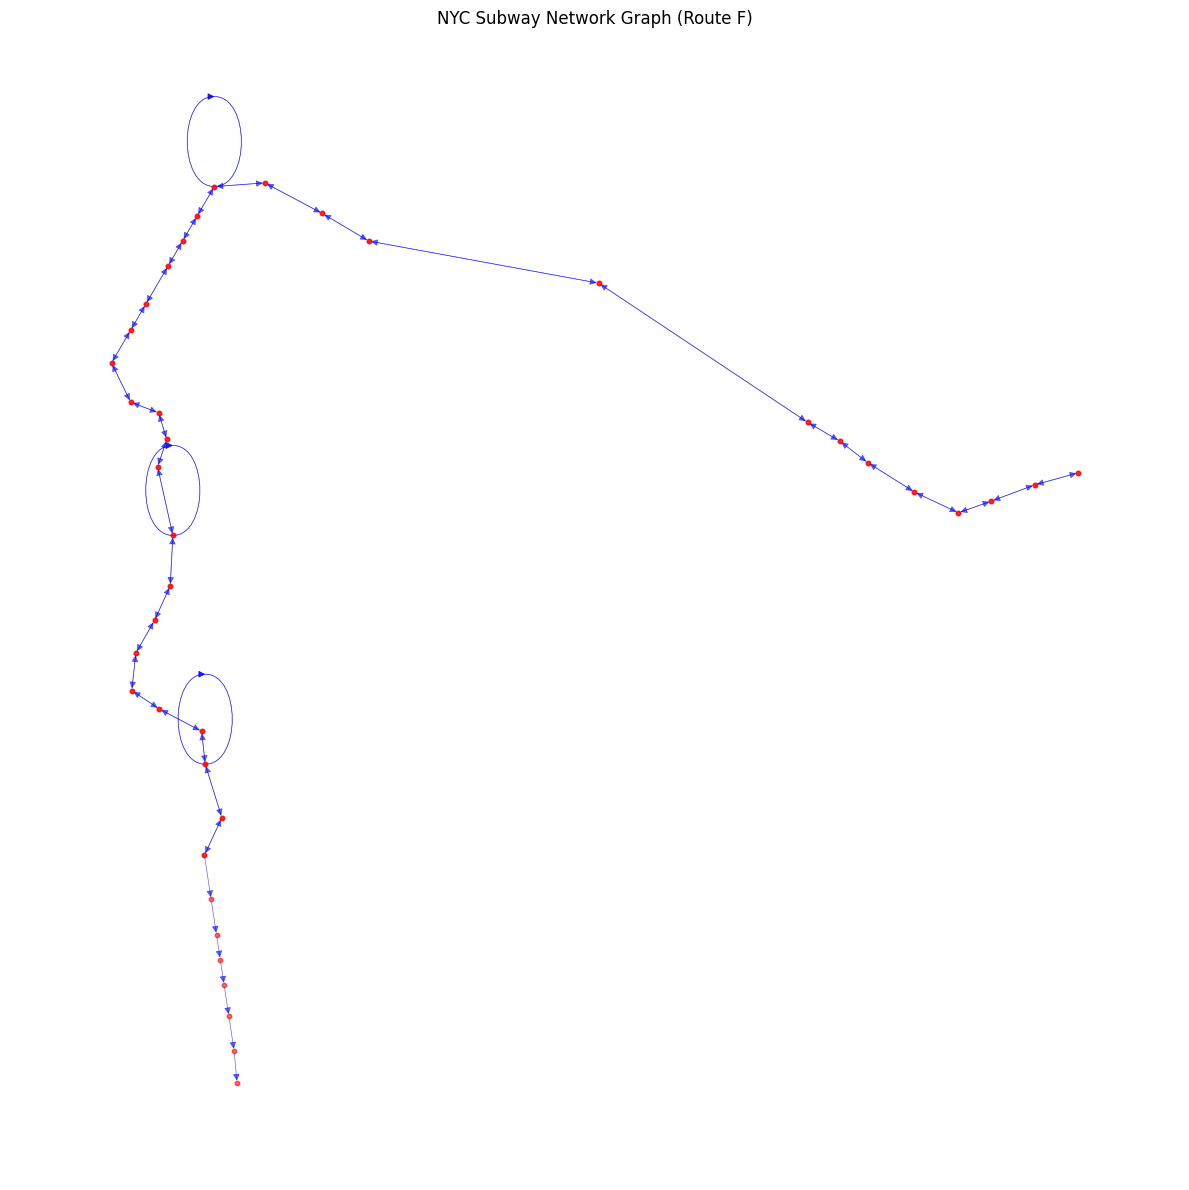

In [31]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Get positions from node attributes
pos = nx.get_node_attributes(G, 'pos')

# Filter nodes with route_id = 'F'
route_ids = nx.get_node_attributes(G, 'route_id')
f_train_nodes = [node for node, route in route_ids.items() if route == 'F']

# Filter positions for F train nodes
pos_filtered = {node: pos[node] for node in f_train_nodes if node in pos}

# Draw the graph with only F train nodes
nx.draw(G.subgraph(f_train_nodes), pos=pos_filtered, ax=ax, node_size=10, node_color='red', edge_color='blue', 
        width=0.5, with_labels=False, alpha=0.6)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NYC Subway Network Graph (Route F)')

plt.tight_layout()
plt.show()

In [32]:
# sanity check

# Find shortest path from 625N_Q to B06N_F
source = 'A31S_A'
target = '127S_1'

try:
    path = nx.shortest_path(G, source=source, target=target, weight='weight')
    path_length = nx.shortest_path_length(G, source=source, target=target, weight='weight')
    
    print(f"Shortest path from {source} to {target}:")
    print(f"Path length: {path_length}")
    print(f"Number of stops: {len(path)}")
    print("\nPath:")
    for i, node in enumerate(path):
        print(f"{i+1}. {node}, {G.nodes[node]['route_id']}, {G.nodes[node]['direction_id']}, {G.nodes[node]['stop_name']}")
except nx.NetworkXNoPath:
    print(f"No path found from {source} to {target}")
except nx.NodeNotFound as e:
    print(f"Node not found: {e}")


Shortest path from A31S_A to 127S_1:
Path length: 3
Number of stops: 7

Path:
1. A31S_A, A, 1, 14 St
2. A32S_A, A, 1, W 4 St-Wash Sq
3. D20N_B, B, 0, W 4 St-Wash Sq
4. D17N_B, B, 0, 34 St-Herald Sq
5. R17N_W, W, 0, 34 St-Herald Sq
6. R16N_W, W, 0, Times Sq-42 St
7. 127S_1, 1, 1, Times Sq-42 St


In [33]:
def get_stop_id_from_route_name_direction(route_id, stop_name, direction=None):
    """
    Get the stop_id for a given route, stop name, and optional direction.
    
    Args:
        route_id: The route identifier
        stop_name: Name of the stop
        direction: 'S' (southbound=1), 'N' (northbound=0), or None for any direction
    
    Returns:
        The stop_id string, or None if no match found.
    """
    direction_map = {'S': 1, 'N': 0}
    
    # Base filter: route and stop name
    mask = (
        (selected_trip_stop_times['route_id'] == route_id) & 
        (selected_trip_stop_times['stop_name'] == stop_name)
    )
    
    # Add direction filter if specified
    if pd.notna(direction):
        direction_id = direction_map.get(direction)
        if direction_id is None:
            raise ValueError(f"Invalid direction '{direction}'. Expected 'N' or 'S'.")
        mask &= (selected_trip_stop_times['direction_id'] == direction_id)
    
    result = selected_trip_stop_times.loc[mask, 'stop_id']
    
    if result.empty:
        return None  # or raise an exception if this should never happen
    
    return result.tolist()

## Results: Accessible Path Matrix

With the network fully constructed, we can now compute shortest paths between all pairs of ADA-accessible stops.

For each accessible stop (defined as a stop + route + direction combination), we calculate the shortest weighted path to every other accessible stop using NetworkX's shortest path algorithm. The results are stored as a nested dictionary mapping origin → destination → path info (full path, hop count, and total weight).
```python
# For each pair of accessible stops, find the shortest path
accessible_paths[from_station][to_station] = {
    'path': [...],      # list of node IDs
    'length': int,      # number of hops
    'weight': float     # total edge weight
}
```

### Room for Improvement

- **Station complex grouping**: Currently, each stop + route + direction is treated as a distinct origin/destination. We could use the transfer adjacency matrix to group stations into complexes and compute complex-to-complex distances instead—but I was too tired for that.
- **Performance**: The brute-force pairwise search is O(n²) and checks all node combinations for each pair. For a production system, precomputing predecessor matrices or using more efficient graph algorithms would help.
- **Weight calibration**: Edge weights currently exist but could be refined (e.g., incorporating real transfer times, elevator wait times, or walking distances).

In [34]:
# final product: for each ada accessible stop, we calculate a path to every other ada accessible stop.

# get a list of all ada accessible stops as stop + route + direction
# potentially could use the transfer info to group complex together but I am too tiered for that.


accessible_stations[['route', 'stop_name', 'direction']]
accessible_stop_ids = []

for _, row in accessible_stations.iterrows():
    stop_ids = get_stop_id_from_route_name_direction(row['route'], row['stop_name'], row['direction'])
    if stop_ids:
        accessible_stop_ids.extend(stop_ids)

accessible_stop_ids[:10]

['L06N',
 'L06S',
 '132N',
 '132S',
 '132N',
 '132S',
 '132N',
 '132S',
 'D19N',
 'D19S']

In [35]:
# Calculate paths between all pairs of accessible stops
from collections import defaultdict

# Store results: {from_stop_id: {to_stop_id: {'path': [...], 'length': int, 'weight': float}}}
accessible_paths = defaultdict(dict)
all_node_ids = list(G.nodes())

In [36]:
selected_trip_stop_times[selected_trip_stop_times['parent_station'] == 'L06']

,route_id,direction_id,stop_id,stop_name,stop_lat,stop_lon,parent_station,stop_sequence
930,L,0,L06N,1 Av,40.730953,-73.981628,L06,20
939,L,1,L06S,1 Av,40.730953,-73.981628,L06,5


In [ ]:
# Store results: {from_stop_id: {to_stop_id: {'path': [...], 'length': int, 'weight': float}}}
accessible_paths = defaultdict(dict)
all_node_ids = list(G.nodes())

# For each accessible station, find matching nodes
def get_nodes_for_station(station_name, all_nodes):
    """Find all nodes that start with the station name"""
    return [node for node in all_nodes if str(node).startswith(station_name)]

# Assuming accessible_stations is a list of station names
for idx, from_station in enumerate(accessible_stop_ids):
    print(f"Processing from_station {idx + 1} of {len(accessible_stop_ids)}: {from_station}")
    from_nodes = get_nodes_for_station(from_station, all_node_ids)

    for to_station in accessible_stop_ids:
        if from_station == to_station:
            continue
            
        to_nodes = get_nodes_for_station(to_station, all_node_ids)
        
        # Find shortest path between any from_node to any to_node
        best_path = None
        best_weight = float('inf')
        
        for from_node in from_nodes:
            for to_node in to_nodes:
                try:
                    # Get shortest path by weight
                    path = nx.shortest_path(G, from_node, to_node, weight='weight')
                    # Calculate total weight
                    weight_sum = sum(
                        G[path[i]][path[i+1]].get('weight', 1) 
                        for i in range(len(path) - 1)
                    )
                    
                    if weight_sum < best_weight:
                        best_weight = weight_sum
                        best_path = path
                        
                except nx.NetworkXNoPath:
                    continue
        
        if best_path is not None:
            accessible_paths[from_station][to_station] = {
                'path': best_path,
                'length': len(best_path),
                'weight': best_weight
            }

In [46]:
import json
import pickle

# Save as JSON
with open('../output/accessible_paths.json', 'w') as f:
    json.dump(accessible_paths, f, indent=2)

# Save as pickle
with open('../output/accessible_paths.pkl', 'wb') as f:
    pickle.dump(accessible_paths, f)

In [47]:
del accessible_paths

*(Apologies for the wall of logs below—couldn't install tqdm, so we're going old school with print statements.)*